This is a placeholder file aiming to remind us that:

Althought there seems to be no big issue in the csv file,
it is important to preprocess the images even before the feature extraction!

I've found an interesting article:
https://medium.com/towards-data-science/medical-image-pre-processing-with-python-d07694852606

# Background Removal

Otsu's method is proven to be really effective:

https://amitprius.medium.com/opencv-adaptive-and-otsu-threshold-in-image-processing-with-python-648b64129876O

https://afetulhak.medium.com/crop-out-unwanted-border-pixels-from-medical-images-or-any-kind-of-image-b3def5dea2db

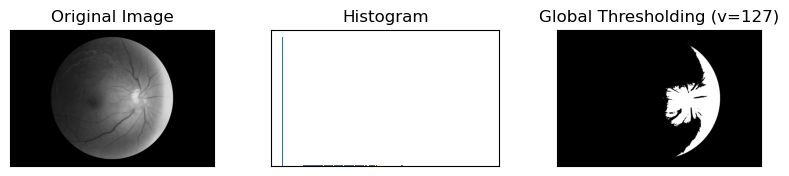

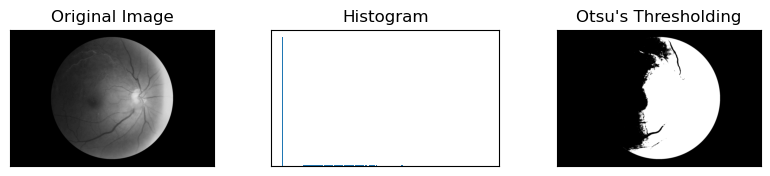

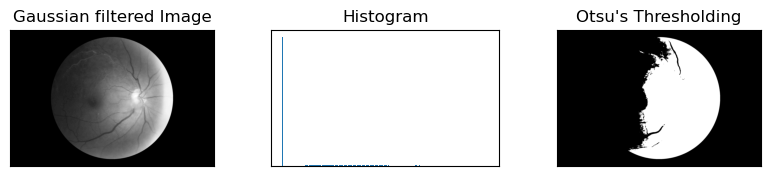

In [1]:
import cv2 as cv
from matplotlib import pyplot as plt

image = cv.imread('images/593_right.jpg')
img = cv.cvtColor(image, cv.COLOR_BGR2GRAY)

 # threshold with the simple binary method
ret1,simp_thresh = cv.threshold(img,127,255,cv.THRESH_BINARY)

# Otsu's threshold without any filter
ret2,simp_thresh_otsu = cv.threshold(img,0,255,cv.THRESH_BINARY+cv.THRESH_OTSU)

# Otsu's threshold using Gaussian filtering
blur = cv.GaussianBlur(img,(5,5),0)
ret3,otsu_filter = cv.threshold(blur,0,255,cv.THRESH_BINARY+cv.THRESH_OTSU)

# histogram of images
images = [img, 0, simp_thresh,
          img, 0, simp_thresh_otsu,
          blur, 0, otsu_filter]

titles = ['Original Image','Histogram','Global Thresholding (v=127)',
          'Original Image','Histogram',"Otsu's Thresholding",
          'Gaussian filtered Image','Histogram',"Otsu's Thresholding"]

# using a loop to visualize the different types of methods
for i in range(3):
    plt.figure(figsize=(10,6))
    plt.subplot(3,3,i*3+1),plt.imshow(images[i*3],'gray')
    plt.title(titles[i*3]), plt.xticks([]), plt.yticks([])
    plt.subplot(3,3,i*3+2),plt.hist(images[i*3].ravel(),256)
    plt.title(titles[i*3+1]), plt.xticks([]), plt.yticks([])
    plt.subplot(3,3,i*3+3),plt.imshow(images[i*3+2],'gray')
    plt.title(titles[i*3+2]), plt.xticks([]), plt.yticks([])

plt.show()


In [8]:
from packages.small_batch_images import *

It indeed removed the background effectively for our endoscopic images

# Image Cropping
following the otsu method, one can crop the image by selecting the bounding Rectangle
https://afetulhak.medium.com/crop-out-unwanted-border-pixels-from-medical-images-or-any-kind-of-image-b3def5dea2db

In [9]:
contours,hierarchy = cv.findContours(otsu_filter,cv.RETR_EXTERNAL,cv.CHAIN_APPROX_SIMPLE)
cnts = sorted(contours, key=cv.contourArea, reverse=True)

x, y, w, h = cv.boundingRect(cnts[0])
crop = image[y:y+h, x:x+w]
cv.imwrite("test.jpg",crop)

True

# Proceed with all images

In [28]:
def equalize(img):
    hsv_img = cv.cvtColor(img, cv.COLOR_BGR2HSV)
    H, S, V = cv.split(hsv_img)
    output_V = cv.equalizeHist(V)
    hsv_img = cv.merge((H, S, V))
    img = cv.cvtColor(hsv_img, cv.COLOR_HSV2BGR)
    return img

In [33]:
# Combine the necessary codes above
def preprocess(image):
    # normalize and equalize the image
    image = cv.normalize(image, None, alpha=0, beta=255, norm_type=cv.NORM_MINMAX, dtype=-1)
    image = equalize(image)
    gray = cv.cvtColor(image, cv.COLOR_BGR2GRAY)
    # Otsu's threshold using Gaussian filtering
    blur = cv.GaussianBlur(gray,(5,5),0)
    ret, otsu_filter = cv.threshold(blur,0,255,cv.THRESH_BINARY+cv.THRESH_OTSU)
    contours, hierarchy = cv.findContours(otsu_filter,cv.RETR_EXTERNAL,cv.CHAIN_APPROX_SIMPLE)
    cnts = sorted(contours, key=cv.contourArea, reverse=True)
    x, y, w, h = cv.boundingRect(cnts[0])
    crop = image[y:y+h, x:x+w]
    return crop

In [34]:
def crop_to_square_and_resize(img):
    h, w = img.shape[:2]
    square_size = min(img[:,:,0].shape)*85//100
    x = w//2 - square_size//2
    y = h//2 - square_size//2
    return cv.resize(img[y:y+square_size, x:x+square_size], (224, 224))

In [35]:
import pandas as pd
import os

df = load_annotation()
for i in range(len(df)):
    img_l = cv.imread(os.path.join(script_dir, "../images/{}").format(df.Left_Fundus.values[i]))
    img_l = preprocess(img_l)
    # script_dir is in the small_batch_images scirpt
    asp_ratio = img_l.shape[0]/img_l.shape[1]
    # drop the images which are cropeed too much
    if asp_ratio < 0.8 or asp_ratio>1.2:
        continue
    img_l = crop_to_square_and_resize(img_l)
    cv.imwrite(os.path.join(script_dir, "../images_cropped/{}").format(df.Left_Fundus.values[i]), img_l)
    img_r = cv.imread(os.path.join(script_dir, "../images/{}").format(df.Right_Fundus.values[i]))
    img_r = preprocess(img_r)
    asp_ratio = img_r.shape[0]/img_r.shape[1]
    if asp_ratio < 0.8 or asp_ratio>1.2:
        continue
    img_r = crop_to_square_and_resize(img_r)
    cv.imwrite(os.path.join(script_dir, "../images_cropped/{}").format(df.Right_Fundus.values[i]), img_r)